In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import os

os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [70]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

In [71]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [72]:
def imshow(img):
    img = torchvision.utils.make_grid(img, nrow=10) # 1行に表示する数
    img = img / 2 + 0.5 # 正規化から元に戻す
    npimg = img.detach().numpy() # tensor型からnumpy型に
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (RGB, H, W) から(H, W, RGB)に変換
    plt.show()

In [73]:
def train(net, criterion, optimizer, epochs, trainloader, input_size):
    losses = []
    output_and_label = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch}, ', end='')
        running_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            img = img.to(device)
            img = img.reshape(-1, input_size)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

In [74]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10('./data', train=True, transform=transform, download=True)
testset = CIFAR10('./data', train=False, transform=transform, download=True)

batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size // 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


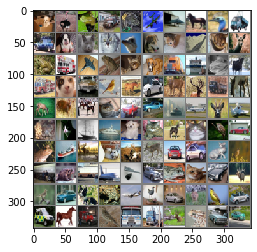

torch.Size([100, 3, 32, 32])


In [75]:
iterator = iter(trainloader)
img, _ = next(iterator)
imshow(img)
print(img.size())

In [76]:
# initで各層を定義しておき，forwardで繋げて利用する．
class AutoEncoder2(torch.nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [77]:
input_size = 3 * 32 * 32

encoder = torch.nn.Sequential(
    torch.nn.Linear(input_size, input_size // 4), # (3072, 768)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size // 12), # (768, 256)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 24) # (256, 128)
)

decoder = torch.nn.Sequential(
    torch.nn.Linear(input_size // 24, input_size // 12), # (128, 256)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 4), # (256, 768)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size), # (768, 3072)
    torch.nn.Tanh()
)

net = AutoEncoder2(encoder, decoder)
net = net.to(device)

In [78]:
criterion = torch.nn.MSELoss() # L2損失に相当
optimizer = torch.optim.SGD(net.parameters(), lr=0.5) # 確率的勾配降下法
EPOCHS = 50

output_and_label, losses = train(
    net, criterion, optimizer, EPOCHS, trainloader, input_size)

epoch: 1, loss: 0.24033459481596947
epoch: 2, loss: 0.1640321879684925
epoch: 3, loss: 0.143556326135993
epoch: 4, loss: 0.13042345502972602
epoch: 5, loss: 0.11992906890809536
epoch: 6, loss: 0.10816557796299457
epoch: 7, loss: 0.10045718039572239
epoch: 8, loss: 0.09709408754110337
epoch: 9, loss: 0.09169229356944561
epoch: 10, loss: 0.08864748072624207
epoch: 11, loss: 0.08660948248207569
epoch: 12, loss: 0.08379194161295891
epoch: 13, loss: 0.08130568094551563
epoch: 14, loss: 0.07934015101194382
epoch: 15, loss: 0.07740345250070095
epoch: 16, loss: 0.07534337635338306
epoch: 17, loss: 0.07366146323084831
epoch: 18, loss: 0.07221259110420943
epoch: 19, loss: 0.07085119891166687
epoch: 20, loss: 0.06958318728208542
epoch: 21, loss: 0.06825429478287696
epoch: 22, loss: 0.06694343072921037
epoch: 23, loss: 0.06581268059462309
epoch: 24, loss: 0.06482493031024933
epoch: 25, loss: 0.06394339293986559
epoch: 26, loss: 0.06314264342188836
epoch: 27, loss: 0.06237002126127481
epoch: 28, lo

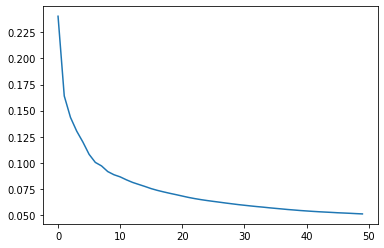

In [79]:
plt.plot(losses)

torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])


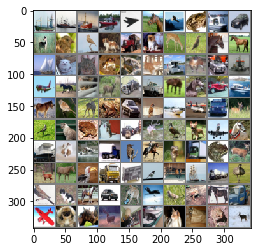

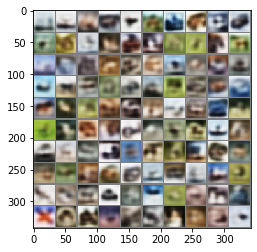

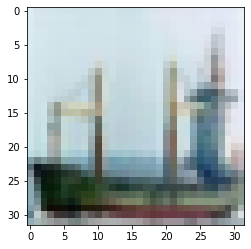

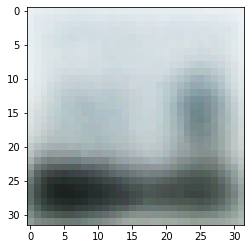

In [84]:
img, org = output_and_label[-1]
img = img.cpu().reshape(-1, 3, 32, 32)
org = org.cpu().reshape(-1, 3, 32, 32)
print(org.shape)
print(img.shape)
imshow(org)
imshow(img)

# orgが元画像，imgが推定した後の画像
imshow(org[0])
imshow(img[0])

### 学習したラベルは使わずにモデルを保存

In [85]:
torch.save(net, '128epch50.pth')
torch.save(output_and_label, 'output_and_label50.pth')
torch.save(net.state_dict(), 'weight_and_bias50.pth')

In [93]:
model_wb = torch.load("./weight_and_bias50.pth")
print(model_wb)
print()

OrderedDict([('enc.0.weight', tensor([[ 0.0098,  0.0090, -0.0046,  ...,  0.0004, -0.0095, -0.0083],
        [ 0.0037, -0.0027,  0.0034,  ..., -0.0209,  0.0008,  0.0030],
        [ 0.0199, -0.0112,  0.0004,  ...,  0.0024, -0.0069,  0.0048],
        ...,
        [ 0.0014, -0.0008,  0.0050,  ...,  0.0208, -0.0121,  0.0165],
        [-0.0055, -0.0146, -0.0026,  ...,  0.0124,  0.0064,  0.0229],
        [ 0.0081,  0.0111,  0.0047,  ...,  0.0165, -0.0005,  0.0108]],
       device='cuda:0')), ('enc.0.bias', tensor([-1.1135e-02, -5.3254e-02, -3.6956e-03, -1.0696e-02, -1.7994e-05,
        -3.5653e-02, -1.2698e-01,  6.5134e-03, -4.8656e-04, -6.2572e-02,
        -1.1672e-01, -1.0492e-01, -5.0727e-02, -7.8451e-02,  5.7690e-03,
        -7.8341e-03,  1.2721e-02, -2.6192e-02, -2.2878e-03,  1.0324e-02,
         1.6051e-02, -5.2047e-02, -2.1312e-02, -1.9877e-02, -1.8405e-02,
        -7.0225e-03,  1.2368e-02,  4.2446e-03,  2.7032e-02,  2.1582e-03,
         1.1846e-03,  1.4870e-03, -4.3458e-02,  1.1273e-0

### エンコーダ部分のみ再定義

In [87]:
class AutoEncoder3(torch.nn.Module):
    def __init__(self, enc):
        super().__init__()
        self.enc = enc
        #self.dec = dec
    def forward(self, x):
        y = self.enc(x)
        #x = self.dec(x)
        return y

input_size = 3 * 32 * 32

encoder3 = torch.nn.Sequential(
    torch.nn.Linear(input_size, input_size // 4), # (3072, 768)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size // 12), # (768, 256)
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 24) # (256, 128)
)

### モデルを評価モードに変更して，テスト用の画像を読み込んで，モデルに渡せる形式にする

In [88]:
model = AutoEncoder3(encoder3)
model = model.to(device)

model.load_state_dict(model_wb, strict=False)
model.eval()

AutoEncoder3(
  (enc): Sequential(
    (0): Linear(in_features=3072, out_features=768, bias=True)
    (1): ReLU()
    (2): Linear(in_features=768, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [89]:
# 学習用データセット：縦横32ピクセルのRGBの画像が50000枚
print(trainset.data.shape)
(50000, 32, 32, 3)

# テスト用データセット：縦横32ピクセルのRGBの画像が10000枚
print(testset.data.shape)
(10000, 32, 32, 3)

# クラス一覧を確認する
print(trainset.classes)

# classesはよく利用するので別途保持しておく
classes = trainset.classes
print(classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 32, 32])


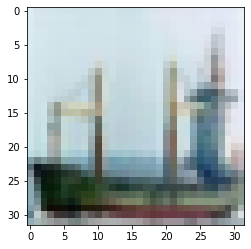

In [91]:
print(org[0].shape)
imshow(org[0])

In [92]:
# CIFAR-10のランダム100枚を学習済みのモデルに入力する
org = org.to(device)
# outputs = model(img)
print(org.shape)

torch.Size([100, 3, 32, 32])


In [101]:
output = model(org[0].flatten()) # 次元合わせのためにflatten()が必要
print(output)

tensor([-1.3035, -2.6512, -1.7879,  1.4514,  2.1553,  0.9088, -0.9486,  0.1641,
         0.8028,  2.1836, -0.8569, -1.0187,  1.2662, -1.5192,  0.2262,  0.9501,
        -2.9540, -0.3396,  2.4453, -0.7289,  0.6418,  0.4982,  1.8148, -0.7154,
         0.9390, -1.4251,  1.4176, -0.6643,  2.2889, -1.2949, -2.0305,  0.7298,
        -0.0219,  0.8594, -0.4368, -1.1668,  0.3225, -0.5944,  0.5562, -1.1078,
        -0.2995,  1.3392, -2.4211, -1.4079,  1.6831, -0.9696,  1.7923, -2.3989,
         0.2133, -0.7795, -1.4346,  0.9569,  1.4001, -0.8040,  0.2544,  0.6156,
         0.4365,  2.4251, -0.1533, -1.2978,  0.1432,  0.3705, -1.7538, -0.0768,
         1.2200,  2.8972,  0.5524, -1.3979, -3.2307,  0.0198, -1.6321,  0.9581,
        -2.0913,  1.2071,  2.9232,  1.7188,  2.0352,  3.5397,  0.5644, -1.4769,
        -0.7887, -3.1193,  0.8545,  2.1929, -2.4807,  0.8407,  0.7415, -0.2601,
        -1.0922,  0.3846,  0.0185, -2.5922,  0.7999, -1.5522,  0.0604, -0.7377,
         1.7018, -1.2766, -0.4280,  1.71

In [125]:
features = []
for i in range(100):
    if i==0:
        features = model(org[i].flatten())
    else:
        temp = model(org[i].flatten())
        features = torch.vstack([features, temp])

print(features.shape)
print(features[1])

torch.Size([100, 128])
tensor([ 0.8637, -2.2617, -2.7342,  1.0420,  2.9958,  0.2791, -0.7306,  0.4543,
         1.2717,  2.7330, -0.5633, -1.0201,  0.6974, -0.7751,  1.0352, -0.3287,
        -2.5657, -1.0624,  3.4351,  0.2505,  0.2219,  0.1559,  1.2982, -1.0106,
         1.8037, -0.3136,  2.4998, -0.6340,  0.5660,  0.4756, -3.2269,  0.2315,
        -0.3878,  2.9948, -0.4737, -1.1490,  0.4029, -0.9280,  0.5301, -0.7706,
         0.4078,  0.9620, -1.7771, -1.4232,  2.4401, -2.3341,  2.5928, -0.7986,
         0.3195, -0.7052, -1.5702,  1.4995,  2.5783, -2.3309,  1.3046, -0.6471,
         1.0202,  2.7797,  0.1674, -2.4060,  0.9050, -0.4952, -2.0303, -1.1100,
         1.9500,  0.7001,  2.4051, -1.8596, -3.9773, -1.0382, -1.7664,  0.5098,
        -2.4456,  1.4105,  1.7141,  1.5311,  2.0799,  4.3074,  0.8963, -2.9114,
         0.4938, -2.9473,  1.4707,  2.6308, -1.8332,  2.1693,  2.0916, -0.8418,
        -0.7103,  1.0276,  0.3425, -3.5972,  1.3302, -3.0243,  0.4747,  0.7196,
         3.2562, 

###  k=5 でk-meansでクラスタリング

In [126]:
feat = features.cpu().detach().numpy()
print(feat)

[[-1.303474   -2.6511576  -1.787947   ... -1.1473544   0.56051517
   0.4460081 ]
 [ 0.86366475 -2.261748   -2.7341979  ... -0.51372635  0.52619535
   1.61315   ]
 [-1.5119437  -0.6734841  -0.7302613  ... -0.9239391   0.15166716
  -0.81821483]
 ...
 [-1.0969235  -0.86000097  0.83373    ...  0.23114133 -1.6468626
   0.13655171]
 [-0.42981023 -1.0198411   0.7854285  ... -0.95048183 -0.25805694
   0.930362  ]
 [-0.2793642  -2.8614912  -1.0544888  ... -1.3342382  -2.465466
  -0.31833243]]


In [ ]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=5, random_state=10).fit